🎨 Affichage du graphique du workflow...
📊 Graphique du workflow LangGraph :


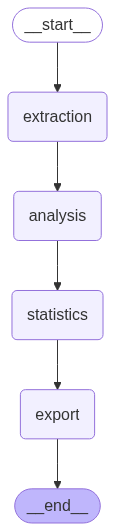


🧪 Test du workflow LangGraph PDF...
🚀 Démarrage du workflow LangGraph...
🔍 Exécution du nœud d'extraction...
✅ Extraction terminée. Fichier sauvé: C:\Users\kosmo\pycode\LangGraph\textes_extraits\2025.5.sante_pages_117-131.txt
🔬 Exécution du nœud d'analyse...
✅ Analyse terminée.
📊 Exécution du nœud d'analyse statistique...
✅ Analyse statistique terminée.
📤 Exécution du nœud d'export...
✅ Export terminé :
   📄 Markdown: 2025.5.sante_analyse_20250707_215207.md
   📕 PDF: 2025.5.sante_analyse_20250707_215207.pdf
   📋 JSON: 2025.5.sante_analyse_20250707_215207.json

=== RÉSULTATS DU WORKFLOW COMPLET ===

📁 PDF traité: 2025.5.sante.pdf
📄 Pages analysées: 117 à 131
💾 Fichier extrait: C:\Users\kosmo\pycode\LangGraph\textes_extraits\2025.5.sante_pages_117-131.txt

📤 Fichiers exportés:
   📄 Markdown: 2025.5.sante_analyse_20250707_215207.md
   📕 PDF: 2025.5.sante_analyse_20250707_215207.pdf
   📋 JSON: 2025.5.sante_analyse_20250707_215207.json

=== ANALYSE DÉTAILLÉE ===
Voici l'analyse des article

In [ ]:
import os
import pdfplumber
import re
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END
from typing import TypedDict, Optional
from reportlab.lib.pagesizes import letter, A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
import json
from datetime import datetime
from IPython.display import Image, display

# Configuration
BASE_DIR = os.path.abspath(r"C:\Users\kosmo\pycode\LangGraph")

# Initialiser le LLM
api_key = os.getenv('OPENAI_API_KEY')
if not api_key:
    print("⚠️ ATTENTION: Utilisez une variable d'environnement  ")
    api_key = "sk-proj-0 MX6_U0pycw_XiZUUtZ4V6Gc5x "

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=api_key
)

# ===== STATE DEFINITION =====

class PDFAnalysisState(TypedDict):
    pdf_filename: str
    start_page: Optional[int]
    end_page: Optional[int]
    extracted_text: Optional[str]
    extracted_file_path: Optional[str]
    analysis_result: Optional[str]
    statistics_result: Optional[str]  # Nouveau champ
    exported_files: Optional[dict]
    error: Optional[str]

# ===== EXTRACTION FUNCTIONS =====

def post_process_text(text):
    """Fonction pour nettoyer et reformater le texte extrait."""
    # Corriger "A\nrticle" en "Article"
    text = re.sub(r'A\s*\n\s*rticle\s+(\d+)', r'Article \1', text)
    
    # Corriger "E\nn cas" en "En cas"
    text = re.sub(r'E\s*\n\s*n cas', r'En cas', text)
    
    # Corriger les sauts de lignes intempestifs dans le texte courant
    text = re.sub(r'(\w)\s*\n\s*(\w)', lambda m: f"{m.group(1)} {m.group(2)}" if not (m.group(2).lower() == 'les' or m.group(1) == '-') else f"{m.group(1)}\n{m.group(2)}", text)
    
    return text

def format_articles(text):
    """Améliore le formatage des articles pour respecter la mise en page désirée"""
    # Mettre "Article XX" sur une ligne séparée et ajouter un saut de ligne après
    text = re.sub(r'\b(Article\s+\d+)\s+', r'\n\1\n\n', text)
    
    # Assurer que "Direction de" commence toujours sur une nouvelle ligne
    text = re.sub(r'([^\n])(Direction de)', r'\1\n\n\2', text)
    
    # Assurer que chaque élément commençant par un tiret est sur une nouvelle ligne
    text = re.sub(r'([^\n])\s*(-\s+)', r'\1\n\2', text)
    
    # Assurer que "dans la limite de ses attributions et fonctions :" est sur sa propre ligne
    text = re.sub(r'(dans la limite de ses attributions et fonctions\s*:)', r'\n\1\n', text)
    
    # S'assurer que le texte après un tiret soit bien séparé de la Direction qui suit
    text = re.sub(r'(afférents\.)\s*(Direction)', r'\1\n\n\2', text)
    text = re.sub(r'(comptes\.)\s*(Direction)', r'\1\n\n\2', text)
    
    # S'assurer que "Bulletin officiel" est au début d'une ligne
    text = re.sub(r'([^\n])(Bulletin officiel)', r'\1\n\2', text)
    
    # Nettoyer les lignes vides multiples (pas plus de 2 consécutives)
    text = re.sub(r'\n{3,}', r'\n\n', text)
    
    return text

def extract_pdf_text(pdf_path: str, output_dir: str = "extracted_text", start_page: int = None, end_page: int = None):
    """Extract text from specified pages of a PDF file and save it to a single file."""
    if not os.path.exists(pdf_path):
        return None, f"Erreur: Fichier non trouvé: {pdf_path}"
    
    # Créer le répertoire de sortie s'il n'existe pas
    os.makedirs(output_dir, exist_ok=True)
    
    # Déterminer la plage de pages
    if not end_page:
        end_page = float('inf')
        
    if not start_page:
        start_page = 1
    
    try:
        with pdfplumber.open(pdf_path) as pdf:
            total_pages = len(pdf.pages)
            
            # Ajuster la plage de pages si nécessaire
            start_idx = max(0, start_page - 1)
            end_idx = min(total_pages, end_page)
            
            # Préparer un seul fichier pour toutes les pages
            pdf_name = os.path.basename(pdf_path).replace(".pdf", "")
            output_filename = f"{pdf_name}_pages_{start_page}-{end_idx}.txt"
            output_path = os.path.join(output_dir, output_filename)
            
            # Extraire et écrire le texte de toutes les pages dans un seul fichier
            extracted_text = ""
            with open(output_path, 'w', encoding='utf-8') as output_file:
                for i in range(start_idx, end_idx):
                    page = pdf.pages[i]
                    page_text = page.extract_text()
                    
                    if page_text:
                        # Post-traitement pour corriger les problèmes de formatage
                        page_text = post_process_text(page_text)
                        
                        # Amélioration du formatage des articles
                        page_text = format_articles(page_text)
                        
                        # Écrire un séparateur de page clair
                        page_content = f"\n\n{'='*20} PAGE {i+1} {'='*20}\n\n{page_text}\n"
                        output_file.write(page_content)
                        extracted_text += page_content
            
            return output_path, extracted_text
            
    except Exception as e:
        return None, f"Erreur lors de l'extraction du texte: {str(e)}"

# ===== LANGGRAPH NODES =====

def extraction_node(state: PDFAnalysisState) -> PDFAnalysisState:
    """Premier nœud : Extraction du PDF"""
    print("🔍 Exécution du nœud d'extraction...")
    
    pdf_filename = state["pdf_filename"]
    start_page = state.get("start_page")
    end_page = state.get("end_page")
    
    # Construire le chemin complet du PDF (corrigé pour Jupyter)
    pdf_paths_to_try = [
        pdf_filename,  # Nom simple dans le répertoire courant
        os.path.join(BASE_DIR, pdf_filename),  # Dans BASE_DIR
        os.path.join(os.getcwd(), pdf_filename),  # Dans le répertoire de travail actuel
        os.path.abspath(pdf_filename)  # Chemin absolu
    ]
    
    pdf_path = None
    for path in pdf_paths_to_try:
        if os.path.exists(path):
            pdf_path = path
            break
    
    if not pdf_path:
        return {
            **state,
            "error": f"Fichier PDF non trouvé: {pdf_filename}\nChemins testés: {pdf_paths_to_try}"
        }
    
    # Extraction
    output_dir = os.path.join(BASE_DIR, "textes_extraits")
    extracted_file_path, extracted_text = extract_pdf_text(pdf_path, output_dir, start_page, end_page)
    
    if not extracted_file_path:
        return {
            **state,
            "error": extracted_text  # extracted_text contient l'erreur dans ce cas
        }
    
    print(f"✅ Extraction terminée. Fichier sauvé: {extracted_file_path}")
    
    return {
        **state,
        "extracted_file_path": extracted_file_path,
        "extracted_text": extracted_text
    }

def analysis_node(state: PDFAnalysisState) -> PDFAnalysisState:
    """Deuxième nœud : Analyse du texte extrait"""
    print("🔬 Exécution du nœud d'analyse...")
    
    if state.get("error"):
        return state
    
    extracted_text = state.get("extracted_text")
    if not extracted_text:
        return {
            **state,
            "error": "Aucun texte extrait à analyser"
        }
    
    try:
        # Prompt d'analyse (version simplifiée du prompt original)
        prompt_text = f"""Vous êtes un expert en analyse de texte juridique et administratif.
Votre spécialité est d'identifier les noms de personnes et leurs rôles
dans des documents officiels, particulièrement les délégations de pouvoir.

Analyse le texte et extrais les informations demandées, en suivant les étapes détaillées ci-dessous.

Chain of Thought pour l'analyse

Instructions générales :
Cette méthode d'analyse doit être appliquée sur l'ensemble du document administratif en procédant article par article. Pour chaque article du document :
1. Isoler le texte de l'article concerné
2. Appliquer la méthode d'analyse décrite dans les exemples ci-dessous
3. Rechercher systématiquement les termes spécifiques et les noms associés
4. Si les termes recherchés n'existent pas dans l'article, indiquer "Non mentionné" pour la catégorie correspondante
5. Compiler les résultats en respectant le format suivant pour chaque article :

Article [Numéro]
[En cas d'absence ou d'empêchement de] : [Nom de la personne ou "Non mentionné"]
[Délégation est donnée à] : [Nom de la personne ou "Non mentionné"]

Exemple 1:

1. Lecture du document :
   Je commence par lire attentivement l'extrait suivant pour en comprendre le contexte et la structure.

   "Délégation est donnée à M. Thomas DUPONT, responsable de l'Unité budget et contrôle interne au sein de la

   Direction des achats et des finances, à l'effet de signer, au nom de la directrice générale de Santé publique France,
   dans la limite de ses attributions et fonctions :

   - l'ensemble des bons de commande d'un montant hors taxe inférieur à 35 000 € ;
   - en cas d'absence ou d'empêchement de la directrice des achats et des finances,
   Mme Sophie MARTIN (épouse DURAND), l'ensemble des bons de commande ;
   - les certifications de service fait sans limitation de montant."

2. Recherche du terme "délégation est donnée" :
   Je cherche si cette expression apparaît dans le texte et j'examine ce qui suit.

   Trouvé : "Délégation est donnée à M. Thomas DUPONT"

   J'identifie donc le nom qui suit cette expression : M. Thomas DUPONT

   Si cette expression n'était pas présente, j'indiquerais "Non mentionné".

   Si cette expression est présente :

   j'identifie la fonction devant le nom de M. Thomas DUPONT : responsable de l'Unité budget et contrôle interne au sein de la Direction des achats et des finances

   la fonction est :  responsable de l'Unité budget et contrôle interne au sein de la Direction des achats et des finances

3. Recherche du terme "en cas d'absence ou d'empêchement" :
   Je cherche si cette expression apparaît dans le texte et j'examine le contexte.

   Trouvé : "en cas d'absence ou d'empêchement de la directrice des achats et des finances, Mme Sophie MARTIN (épouse DURAND)"

   Dans ce contexte, je comprends que Mme Sophie MARTIN (épouse DURAND) est mentionnée comme la directrice des achats et des finances.

   Si cette expression n'était pas présente, j'indiquerais "Non mentionné".

   Si cette expression est présente j'identife également la fonction devant le nom de Mme Sophie MARTIN (épouse DURAND) : directrice des achats et des finances

   la fonction est : directrice des achats et des finances

4. Format de sortie :
   Je structure les informations collectées selon le format demandé.

   [En cas d'absence ou d'empêchement de] : Mme Sophie MARTIN (épouse DURAND) , fonction : directrice des achats et des finances
   [Délégation est donnée à] : M. Thomas DUPONT , fonction : responsable de l'Unité budget et contrôle interne au sein de la Direction des achats et des finances

Exemple 2:

1. Lecture du document :
   Je commence par lire attentivement l'extrait suivant pour en comprendre le contexte et la structure.

   "En cas d'absence ou d'empêchement de Mme Sophia DUBOIS, directrice de l'aide et diffusion aux publics, délégation est donnée à Mme Camille LAURENT, adjointe, dans la limite de ses attributions et fonctions :

   - les engagements financiers relatifs à l'activité de la

   Direction de l'aide et diffusion aux publics d'un montant hors taxe inférieur à 25 000 € et les engagements contractuels afférents ;
   - les lettres de mission envoyées à des collaborateurs externes pour la relecture de rapports produits par Santé publique France avec la mention du montant d'indemnisation de la vacation ;
   - toute décision relative aux opérations d'inventaire dans le cadre de l'arrêté annuel des comptes."

2. Recherche du terme "En cas d'absence ou d'empêchement de" :
   Je cherche cette expression dans le texte et j'examine ce qui suit.

   Trouvé : "En cas d'absence ou d'empêchement de Mme Sophia DUBOIS"

   J'identifie donc le nom qui suit cette expression : Mme Sophia DUBOIS

   Si cette expression n'était pas présente, j'indiquerais "Non mentionné".

   Si cette expression est présente j'identife également la fonction devant le nom de Mme Sophia DUBOIS : directrice de l'aide et diffusion aux publics

   la fonction est : directrice de l'aide et diffusion aux publics

3. Recherche du terme "délégation est donnée à" :
   Je cherche cette expression dans le texte et j'examine ce qui suit.

   Trouvé : "délégation est donnée à Mme Camille LAURENT"

   J'identifie donc le nom qui suit cette expression : Mme Camille LAURENT

   Si cette expression n'était pas présente, j'indiquerais "Non mentionné".

   Si cette expression est présente j'identife également la fonction devant le nom de Mme Camille LAURENT : adjointe

   la fonction est : adjointe

4. Format de sortie :
   Je structure les informations collectées selon le format demandé.

   [En cas d'absence ou d'empêchement de] : Mme Sophia DUBOIS fonction : directrice de l'aide et diffusion aux publics
   [Délégation est donnée à] : Mme Camille LAURENT fonction : adjointe

Le résultat final pour l'ensemble du document ressemblera à ceci :

Voici l'exemple formaté avec des noms et prénoms fictifs :

  Exemple 3:  

  1. Lecture du document :  
   Je commence par lire attentivement l'extrait suivant pour en comprendre le contexte et la structure.

   *"Délégation est donnée aux gestionnaires de l'Unité pilotage et exécution financière au sein de la Direction des achats et des finances, personnes dont la liste suit, de signer, au nom de la directrice générale de Santé publique France, les certifications de service fait d'un montant hors taxe inférieur à 1 000 € :*
   
   *Mme Amélie BERNARD ;*
   *M. Julien MOREAU ;*
   *Mme Sarah DUBOIS ;*
   *M. Pierre LEFEBVRE."*

  2. Recherche du terme "délégation est donnée" :  
   Je cherche si cette expression apparaît dans le texte et j'examine ce qui suit.

     Trouvé :   *"Délégation est donnée aux gestionnaires de l'Unité pilotage et exécution financière"*

   J'identifie que la délégation est donnée à plusieurs personnes listées. Je note que devant "Délégation est donnée" se trouve la fonction collective : *gestionnaires de l'Unité pilotage et exécution financière au sein de la Direction des achats et des finances*

   Puisque les noms individuels (Mme Amélie BERNARD, M. Julien MOREAU, Mme Sarah DUBOIS, M. Pierre LEFEBVRE) n'ont pas de fonction spécifique mentionnée devant chaque nom, je comprends qu'ils partagent tous la même fonction mentionnée après "Délégation est donnée aux".

     La fonction commune est :   gestionnaires de l'Unité pilotage et exécution financière au sein de la Direction des achats et des finances

  3. Recherche du terme "en cas d'absence ou d'empêchement" :  
   Je cherche si cette expression apparaît dans le texte et j'examine le contexte.

     Non trouvé :   cette expression n'apparaît pas dans ce texte.

   Si cette expression n'est pas présente, j'indique "Non mentionné".

  4. Format de sortie :  
   Je structure les informations collectées selon le format demandé.

     [En cas d'absence ou d'empêchement de] :   Non mentionné
     [Délégation est donnée à] :   Mme Amélie BERNARD, M. Julien MOREAU, Mme Sarah DUBOIS, M. Pierre LEFEBVRE, fonction : gestionnaires de l'Unité pilotage et exécution financière au sein de la Direction des achats et des finances

Article 11
[En cas d'absence ou d'empêchement de] : Non mentionné
[Délégation est donnée à] : Mme Amélie BERNARD, M. Julien MOREAU, Mme Sarah DUBOIS, M. Pierre LEFEBVRE, fonction : gestionnaires de l'Unité pilotage et exécution financière au sein de la Direction des achats et des finances

Article 22
[En cas d'absence ou d'empêchement de] : Mme Sophia DUBOIS fonction : directrice de l'aide et diffusion aux publics
[Délégation est donnée à] : Mme Camille LAURENT fonction : adjointe

Article 8
[En cas d'absence ou d'empêchement de] : Mme Sophie MARTIN (épouse DURAND) fonction : directrice des achats et des finances
[Délégation est donnée à] : M. Thomas DUPONT fonction : responsable de l'Unité budget et contrôle interne au sein de la Direction des achats et des finances

Article 15
[En cas d'absence ou d'empêchement de] : Non mentionné
[Délégation est donnée à] : Non mentionné

Analysez le texte suivant :

 
{extracted_text}"""
        
        analysis_prompt_template = ChatPromptTemplate.from_messages([
            ("human", prompt_text)
        ])
        
        prompt_value = analysis_prompt_template.invoke({})
        response = llm.invoke(prompt_value.to_messages())
        
        print("✅ Analyse terminée.")
        
        return {
            **state,
            "analysis_result": response.content
        }
        
    except Exception as e:
        return {
            **state,
            "error": f"Erreur lors de l'analyse: {str(e)}"
        }
    
    
    
    
def statistics_node(state: PDFAnalysisState) -> PDFAnalysisState:
    """Quatrième nœud : Analyse statistique des résultats"""
    print("📊 Exécution du nœud d'analyse statistique...")
    
    if state.get("error"):
        return state
    
    analysis_result = state.get("analysis_result")
    if not analysis_result:
        return {
            **state,
            "error": "Aucun résultat d'analyse pour les statistiques"
        }
    
    try:
        # Prompt d'analyse statistique
        stats_prompt = f"""Vous êtes un expert en analyse statistique de documents administratifs et juridiques.
Votre spécialité est d'analyser les patterns, tendances et insights dans les délégations de pouvoir.

Analysez les résultats suivants en suivant une approche Chain of Thought méthodique.

=== MÉTHODE D'ANALYSE STEP-BY-STEP ===

Étape 1: Collecte et inventaire des données
- Compter le nombre total d'articles analysés
- Identifier les articles avec délégations vs articles sans délégations
- Recenser tous les noms et fonctions mentionnés

Étape 2: Analyse des patterns de délégation
- Analyser les types de fonctions qui reçoivent des délégations
- Identifier les directions/services les plus représentés
- Examiner les patterns de noms (genre, fréquence)

Étape 3: Analyse des mécanismes de substitution
- Compter les articles avec mécanismes "en cas d'absence ou d'empêchement"
- Analyser les relations hiérarchiques (qui remplace qui)
- Identifier les postes clés avec ou sans suppléants

Étape 4: Analyse des anomalies et cas particuliers
- Détecter les articles sans délégation explicite
- Identifier les délégations multiples (plusieurs personnes)
- Repérer les fonctions atypiques ou uniques

Étape 5: Synthèse statistique et insights
- Calculer les pourcentages et ratios clés
- Identifier les tendances organisationnelles
- Proposer des recommandations d'amélioration

=== EXEMPLE D'ANALYSE ===

Résultats d'entrée:
Article 8: [Délégation] M. Thomas DUPONT, [Empêchement] Mme Sophie MARTIN
Article 11: [Délégation] 4 personnes gestionnaires, [Empêchement] Non mentionné
Article 15: [Délégation] Non mentionné, [Empêchement] Non mentionné
Article 22: [Délégation] Mme Camille LAURENT, [Empêchement] Mme Sophia DUBOIS

Analyse step-by-step:

Étape 1 - Inventaire:
- Nombre d'articles: 4
- Articles avec délégation: 3 (75%)
- Articles sans délégation: 1 (25%)
- Total personnes identifiées: 7 personnes

Étape 2 - Patterns de délégation:
- Délégations individuelles: 2 articles (50%)
- Délégations multiples: 1 article (25%)
- Fonctions directions: 2 (directrice aide/diffusion, directrice achats/finances)
- Fonctions opérationnelles: 2 (responsable unité, gestionnaires)

Étape 3 - Mécanismes de substitution:
- Articles avec suppléant: 2/4 (50%)
- Relations hiérarchiques identifiées: 2
- Couverture de suppléance: Partielle (50%)

Étape 4 - Anomalies:
- Article 15: Aucune délégation (nécessite vérification)
- Article 11: Délégation multiple sans suppléant (risque opérationnel)

Étape 5 - Insights:
- Taux de délégation acceptable (75%)
- Couverture de suppléance insuffisante (50%)
- Recommandation: Définir suppléants pour articles 11 et 15

=== VOTRE ANALYSE ===

Analysez maintenant les résultats suivants selon cette méthode:

{analysis_result}

Fournissez une analyse complète en suivant les 5 étapes, avec des chiffres précis, des pourcentages, et des recommandations concrètes."""

        # Appel au LLM pour l'analyse statistique
        stats_prompt_template = ChatPromptTemplate.from_messages([
            ("human", stats_prompt)
        ])
        
        prompt_value = stats_prompt_template.invoke({})
        response = llm.invoke(prompt_value.to_messages())
        
        print("✅ Analyse statistique terminée.")
        
        return {
            **state,
            "statistics_result": response.content
        }
        
    except Exception as e:
        return {
            **state,
            "error": f"Erreur lors de l'analyse statistique: {str(e)}"
        }
def export_node(state: PDFAnalysisState) -> PDFAnalysisState:
    """Troisième nœud : Export des résultats en plusieurs formats"""
    print("📤 Exécution du nœud d'export...")
    
    if state.get("error"):
        return state
    
    analysis_result = state.get("analysis_result")
    if not analysis_result:
        return {
            **state,
            "error": "Aucun résultat d'analyse à exporter"
        }
    
    try:
        pdf_filename = state["pdf_filename"]
        pdf_name = os.path.splitext(pdf_filename)[0]  # Nom sans extension
        
        # Déterminer le répertoire de sortie (même que le PDF source)
        pdf_path = None
        pdf_paths_to_try = [
            pdf_filename,
            os.path.join(BASE_DIR, pdf_filename),
            os.path.join(os.getcwd(), pdf_filename),
            os.path.abspath(pdf_filename)
        ]
        
        for path in pdf_paths_to_try:
            if os.path.exists(path):
                pdf_path = path
                break
        
        if pdf_path:
            output_dir = os.path.dirname(pdf_path)
        else:
            output_dir = BASE_DIR
        
        # Timestamp pour les fichiers
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # 1. Export en Markdown
        markdown_file = os.path.join(output_dir, f"{pdf_name}_analyse_{timestamp}.md")
        create_markdown_export(analysis_result, markdown_file, state)
        
        # 2. Export en PDF
        pdf_file = os.path.join(output_dir, f"{pdf_name}_analyse_{timestamp}.pdf")
        create_pdf_export(analysis_result, pdf_file, state)
        
        # 3. Export en JSON
        json_file = os.path.join(output_dir, f"{pdf_name}_analyse_{timestamp}.json")
        create_json_export(analysis_result, json_file, state)
        
        print(f"✅ Export terminé :")
        print(f"   📄 Markdown: {markdown_file}")
        print(f"   📕 PDF: {pdf_file}")
        print(f"   📋 JSON: {json_file}")
        
        return {
            **state,
            "exported_files": {
                "markdown": markdown_file,
                "pdf": pdf_file,
                "json": json_file
            }
        }
        
    except Exception as e:
        return {
            **state,
            "error": f"Erreur lors de l'export: {str(e)}"
        }

def create_markdown_export(analysis_result: str, output_file: str, state: PDFAnalysisState):
    """Créer un export Markdown structuré avec statistiques"""
    statistics_result = state.get('statistics_result', 'Aucune analyse statistique disponible')
    
    content = f"""# Analyse de délégations de pouvoir

## Informations du document
- **Fichier source :** {state['pdf_filename']}
- **Pages analysées :** {state.get('start_page', 'début')} à {state.get('end_page', 'fin')}
- **Date d'analyse :** {datetime.now().strftime("%d/%m/%Y à %H:%M")}

---

## Résultats de l'analyse détaillée

{analysis_result}

---

## Analyse statistique et insights

{statistics_result}

---

## Métadonnées
- Fichier extrait : `{state.get('extracted_file_path', 'N/A')}`
- Outil d'analyse : LangGraph + GPT-4o-mini
"""
    
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(content)

def create_pdf_export(analysis_result: str, output_file: str, state: PDFAnalysisState):
    """Créer un export PDF professionnel avec statistiques"""
    doc = SimpleDocTemplate(output_file, pagesize=A4)
    styles = getSampleStyleSheet()
    
    # Styles personnalisés
    title_style = ParagraphStyle(
        'CustomTitle',
        parent=styles['Heading1'],
        fontSize=16,
        spaceAfter=30,
        textColor='darkblue'
    )
    
    heading_style = ParagraphStyle(
        'CustomHeading',
        parent=styles['Heading2'],
        fontSize=12,
        spaceAfter=12,
        textColor='darkgreen'
    )
    
    stats_style = ParagraphStyle(
        'StatsHeading',
        parent=styles['Heading2'],
        fontSize=12,
        spaceAfter=12,
        textColor='darkorange'
    )
    
    content = []
    
    # Titre
    content.append(Paragraph("Analyse de délégations de pouvoir", title_style))
    content.append(Spacer(1, 20))
    
    # Informations du document
    content.append(Paragraph("Informations du document", heading_style))
    content.append(Paragraph(f"<b>Fichier source :</b> {state['pdf_filename']}", styles['Normal']))
    content.append(Paragraph(f"<b>Pages analysées :</b> {state.get('start_page', 'début')} à {state.get('end_page', 'fin')}", styles['Normal']))
    content.append(Paragraph(f"<b>Date d'analyse :</b> {datetime.now().strftime('%d/%m/%Y à %H:%M')}", styles['Normal']))
    content.append(Spacer(1, 20))
    
    # Résultats détaillés
    content.append(Paragraph("Résultats de l'analyse détaillée", heading_style))
    for line in analysis_result.split('\n'):
        if line.strip():
            if line.startswith('Article'):
                content.append(Paragraph(f"<b>{line}</b>", styles['Normal']))
            else:
                content.append(Paragraph(line, styles['Normal']))
        content.append(Spacer(1, 6))
    
    content.append(Spacer(1, 20))
    
    # Analyse statistique
    content.append(Paragraph("Analyse statistique et insights", stats_style))
    statistics_result = state.get('statistics_result', 'Aucune analyse statistique disponible')
    for line in statistics_result.split('\n'):
        if line.strip():
            content.append(Paragraph(line, styles['Normal']))
        content.append(Spacer(1, 6))
    
    doc.build(content)

def parse_analysis_result(analysis_result: str):
    """Parser le résultat d'analyse pour extraire les données structurées"""
    articles = []
    current_article = None
    
    for line in analysis_result.split('\n'):
        line = line.strip()
        if line.startswith('Article'):
            if current_article:
                articles.append(current_article)
            current_article = {
                "numero": line,
                "absence_empechement": None,
                "delegation_donnee": None
            }
        elif line.startswith('[En cas d\'absence'):
            if current_article:
                current_article["absence_empechement"] = line.split(' : ', 1)[1] if ' : ' in line else "Non mentionné"
        elif line.startswith('[Délégation est donnée'):
            if current_article:
                current_article["delegation_donnee"] = line.split(' : ', 1)[1] if ' : ' in line else "Non mentionné"
    
    if current_article:
        articles.append(current_article)
    
    return articles

def compute_basic_metrics(articles):
    """Calculer des métriques de base à partir des articles parsés"""
    if not articles:
        return {}
    
    total_articles = len(articles)
    articles_with_delegation = sum(1 for a in articles if a.get('delegation_donnee') and 'Non mentionné' not in a['delegation_donnee'])
    articles_with_substitution = sum(1 for a in articles if a.get('absence_empechement') and 'Non mentionné' not in a['absence_empechement'])
    
    return {
        "total_articles": total_articles,
        "articles_with_delegation": articles_with_delegation,
        "articles_with_substitution": articles_with_substitution,
        "delegation_rate": round(articles_with_delegation / total_articles * 100, 1) if total_articles > 0 else 0,
        "substitution_rate": round(articles_with_substitution / total_articles * 100, 1) if total_articles > 0 else 0
    }



def create_json_export(analysis_result: str, output_file: str, state: PDFAnalysisState):
    """Créer un export JSON structuré avec statistiques"""
    # Parser le résultat pour extraire les données structurées
    articles = parse_analysis_result(analysis_result)
    
    export_data = {
        "metadata": {
            "source_file": state['pdf_filename'],
            "pages_analyzed": f"{state.get('start_page', 'début')} à {state.get('end_page', 'fin')}",
            "analysis_date": datetime.now().isoformat(),
            "extracted_file": state.get('extracted_file_path', 'N/A'),
            "tool": "LangGraph + GPT-4o-mini"
        },
        "detailed_analysis": {
            "articles": articles,
            "raw_result": analysis_result
        },
        "statistical_analysis": {
            "raw_statistics": state.get('statistics_result', 'Aucune analyse statistique disponible'),
            "computed_metrics": compute_basic_metrics(articles)
        }
    }
    
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(export_data, f, ensure_ascii=False, indent=2)


# Modifiez la fonction create_pdf_analysis_workflow pour inclure le nouveau nœud
def create_pdf_analysis_workflow():
    """Créer le workflow LangGraph avec analyse statistique"""
    workflow = StateGraph(PDFAnalysisState)
    
    # Ajouter les nœuds
    workflow.add_node("extraction", extraction_node)
    workflow.add_node("analysis", analysis_node)
    workflow.add_node("statistics", statistics_node)  # Nouveau nœud
    workflow.add_node("export", export_node)
    
    # Définir les transitions
    workflow.set_entry_point("extraction")
    workflow.add_edge("extraction", "analysis")
    workflow.add_edge("analysis", "statistics")  # Nouvelle transition
    workflow.add_edge("statistics", "export")    # Transition modifiée
    workflow.add_edge("export", END)
    
    return workflow.compile()

# ===== FONCTION PRINCIPALE =====

def display_workflow_graph():
    """Afficher le graphique du workflow LangGraph"""
    try:
        # Créer le workflow
        workflow = create_pdf_analysis_workflow()
        
        # Afficher le graphique
        print("📊 Graphique du workflow LangGraph :")
        display(Image(workflow.get_graph().draw_mermaid_png()))
        
    except Exception as e:
        print(f"❌ Erreur lors de l'affichage du graphique : {e}")
        print("💡 Assurez-vous d'avoir installé : pip install pygraphviz")

def process_pdf(pdf_filename: str, start_page: int = None, end_page: int = None):
    """
    Traite un PDF avec le workflow LangGraph
    
    Args:
        pdf_filename (str): Nom du fichier PDF
        start_page (int): Première page à extraire (optionnel)
        end_page (int): Dernière page à extraire (optionnel)
    
    Returns:
        dict: Résultat final du workflow
    """
    # Créer le workflow
    workflow = create_pdf_analysis_workflow()
    
    # État initial (mis à jour avec les nouveaux champs)
    initial_state = {
        "pdf_filename": pdf_filename,
        "start_page": start_page,
        "end_page": end_page,
        "extracted_text": None,
        "extracted_file_path": None,
        "analysis_result": None,
        "statistics_result": None,  # Nouveau champ
        "exported_files": None,     # Nouveau champ
        "error": None
    }
    
    print("🚀 Démarrage du workflow LangGraph...")
    
    # Exécuter le workflow
    final_state = workflow.invoke(initial_state)
    
    return final_state

def show_final_results(result):
    """Afficher les résultats finaux avec statistiques"""
    if result.get("error"):
        print(f"❌ Erreur : {result['error']}")
    else:
        print(f"""
=== RÉSULTATS DU WORKFLOW COMPLET ===

📁 PDF traité: {result['pdf_filename']}
📄 Pages analysées: {result.get('start_page', 'début')} à {result.get('end_page', 'fin')}
💾 Fichier extrait: {result.get('extracted_file_path', 'N/A')}

📤 Fichiers exportés:
   📄 Markdown: {result.get('exported_files', {}).get('markdown', 'N/A')}
   📕 PDF: {result.get('exported_files', {}).get('pdf', 'N/A')}
   📋 JSON: {result.get('exported_files', {}).get('json', 'N/A')}

=== ANALYSE DÉTAILLÉE ===
{result.get('analysis_result', 'Aucun résultat')}

=== ANALYSE STATISTIQUE ===
{result.get('statistics_result', 'Aucune analyse statistique')}

✅ Workflow terminé avec succès !
        """)

if __name__ == "__main__":
    # Afficher le graphique du workflow
    print("🎨 Affichage du graphique du workflow...")
    display_workflow_graph()
    
    # Test du workflow
    print("\n🧪 Test du workflow LangGraph PDF...")
    
    # Exemple d'utilisation
    result = process_pdf("2025.5.sante.pdf", 117, 131)
    
    # Utiliser la nouvelle fonction d'affichage
    show_final_results(result)

# Pour une utilisation interactive dans Jupyter
print("🔧 Code modifié pour fonctionner dans Jupyter Notebook")
print("📊 Workflow complet : Extraction → Analyse → Statistiques → Export")
print("📊 Utilisez : display_workflow_graph() pour voir le graphique")
print("📝 Utilisez : result = process_pdf('2025.5.sante.pdf', 117, 131)")
print("📋 Utilisez : show_final_results(result) pour voir tous les résultats")

# Fonction pour afficher juste le graphique (pratique pour les tests)
def show_graph():
    """Version courte pour afficher rapidement le graphique"""
    workflow = create_pdf_analysis_workflow()
    display(Image(workflow.get_graph().draw_mermaid_png()))

# Fonction pratique pour lancer tout d'un coup
def run_complete_analysis(pdf_filename="2025.5.sante.pdf", start_page=117, end_page=131):
    """Fonction tout-en-un pour l'analyse complète"""
    print("🎯 Lancement de l'analyse complète...")
    
    # Afficher le graphique
    display_workflow_graph()
    
    # Exécuter l'analyse
    result = process_pdf(pdf_filename, start_page, end_page)
    
    # Afficher les résultats
    show_final_results(result)
    
    return result